In [1]:
import matplotlib.pyplot as plt  # plotting library
import numpy as np
import pandas as pd
import random

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import einops
from einops.layers.torch import Rearrange


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Selected device: {device}")

data_dir = "dataset"

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = test_transform = transforms.ToTensor()
train_dataset.transform = train_transform
test_dataset.transform = test_transform

m = len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m - m * 0.2), int(m * 0.2)])
batch_size = 256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

Selected device: cuda


In [32]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.main_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=0), # 1x28x28 -> 32x12x12
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=0), # 32x12x12 -> 64x4x4
            nn.ReLU(),
            Rearrange("b c h w -> b (c h w)"),
            nn.Linear(64*4*4, 64*4*4),
            nn.ReLU(),
        )
        self.mu = nn.Sequential(
            nn.LazyLinear(latent_dims),
        )
        self.log_var = nn.Sequential(
            nn.LazyLinear(latent_dims),
            nn.ReLU(),
        )

    def sample(self, mu, log_var):
        std = log_var.mul(0.5).exp_()
        esp = torch.randn(*std.size()).to(device)
        z = mu + std * esp
        return z

    def forward(self, x):
        x = x.to(device)
        x = self.main_block(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.sample(mu, log_var)
        return z, mu, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.main_block = nn.Sequential(
            nn.Linear(latent_dims, 64*4*4),
            nn.ReLU(),
            Rearrange("b (c h w) -> b c h w", c=64, h=4, w=4),
            nn.ConvTranspose2d(64, 32, 5, stride=2, output_padding=1), # 64x4x4 -> 32x12x12
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 5, stride=2, output_padding=1), # 32x12x12 -> 1x28x28
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.to(device)
        return self.main_block(x)


class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z, mu, log_var = self.encoder(x)
        return self.decoder(z), z, mu, log_var


In [33]:
### Set the random seed for reproducible results
torch.manual_seed(0)

latent_dims = 30
vae = VariationalAutoencoder(latent_dims=latent_dims)

lr = 1e-3
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

vae.to(device)


/home/advait/miniconda3/envs/rohan/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


VariationalAutoencoder(
  (encoder): Encoder(
    (main_block): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
      (3): ReLU()
      (4): Rearrange('b c h w -> b (c h w)')
      (5): Linear(in_features=1024, out_features=1024, bias=True)
      (6): ReLU()
    )
    (mu): Sequential(
      (0): LazyLinear(in_features=0, out_features=30, bias=True)
      (1): ReLU()
    )
    (log_var): Sequential(
      (0): LazyLinear(in_features=0, out_features=30, bias=True)
      (1): ReLU()
    )
  )
  (decoder): Decoder(
    (main_block): Sequential(
      (0): Linear(in_features=30, out_features=1024, bias=True)
      (1): ReLU()
      (2): Rearrange('b (c h w) -> b c h w', c=64, h=4, w=4)
      (3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
      (4): ReLU()
      (5): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
   

In [34]:
def loss_function(x_hat, x, mu, log_var):
    bce = F.binary_cross_entropy(x_hat, x, reduction="sum")
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return bce + kl


def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader:
        # Move tensor to the proper device
        x = x.to(device)
        x_hat, _, mu, log_var = vae(x)
        loss = loss_function(x_hat, x, mu, log_var)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    return train_loss / len(dataloader.dataset)


def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad():  # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            x_hat, _, mu, log_var = vae(x)
            loss = loss_function(x_hat, x, mu, log_var)
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)


def plot_ae_outputs(vae, n=10):
    plt.figure(figsize=(16, 4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i: np.where(targets == i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        vae.eval()
        with torch.no_grad():
            x_hat, _, _, _ = vae(img)
        plt.imshow(img.cpu().squeeze().numpy(), cmap="gist_gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Original images")
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_hat.cpu().squeeze().numpy(), cmap="gist_gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Reconstructed images")
    plt.show()


Beginning training


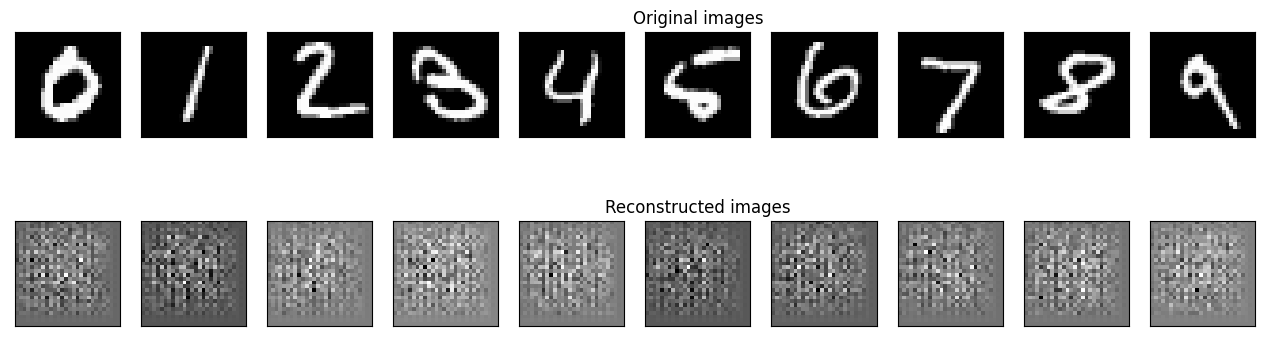


 EPOCH 1/500 	 train loss 330.032 	 val loss 260.567


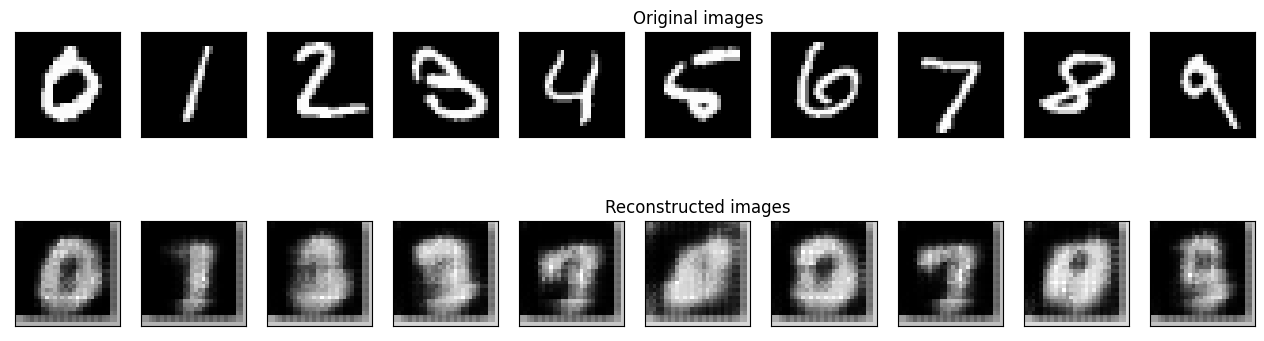


 EPOCH 2/500 	 train loss 235.593 	 val loss 219.436


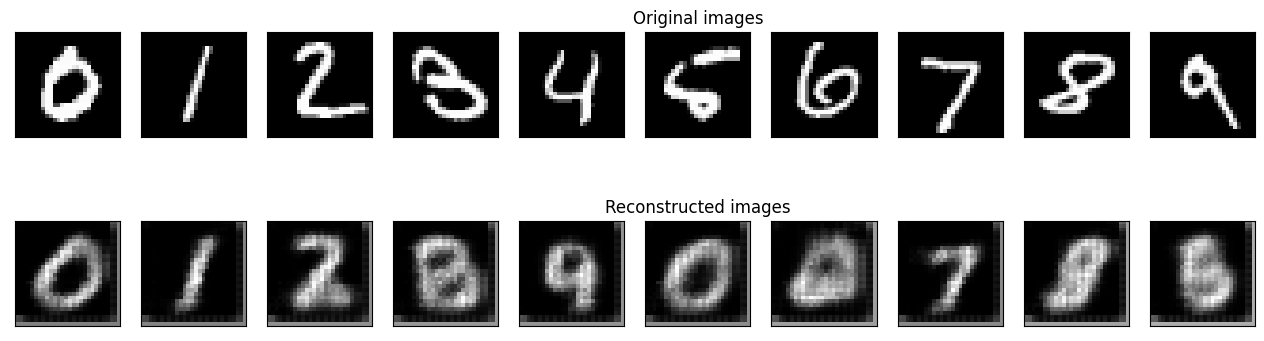


 EPOCH 3/500 	 train loss 210.444 	 val loss 204.586


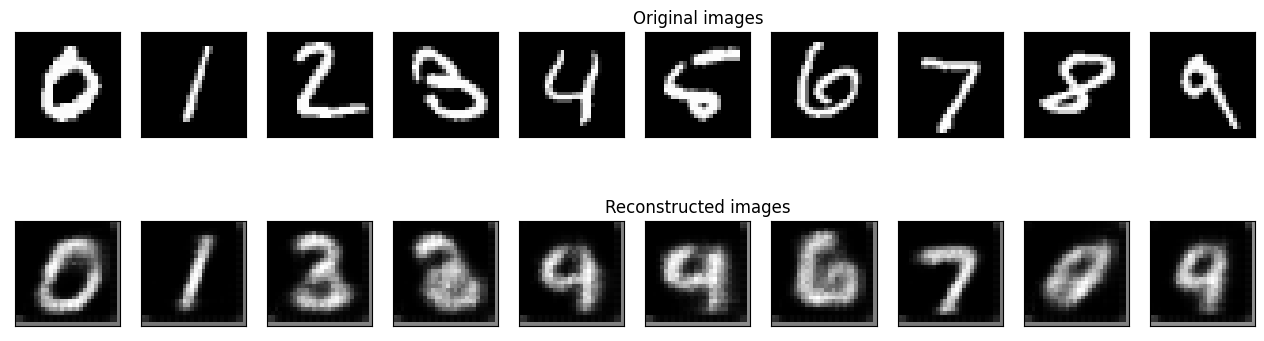


 EPOCH 4/500 	 train loss 200.449 	 val loss 198.041


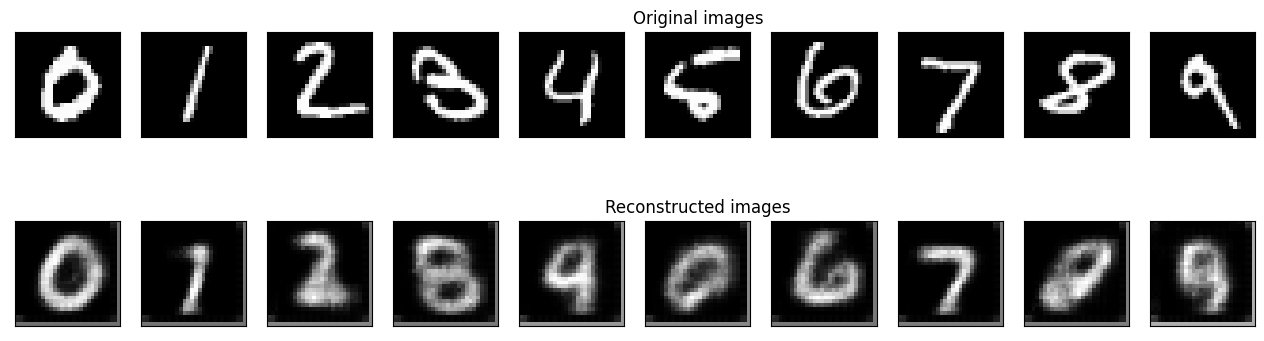


 EPOCH 5/500 	 train loss 194.940 	 val loss 193.369


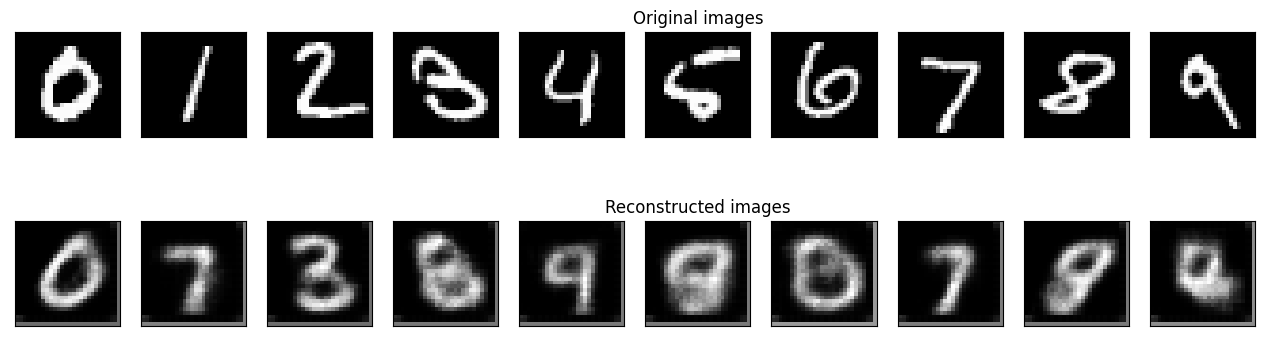


 EPOCH 6/500 	 train loss 191.008 	 val loss 189.825


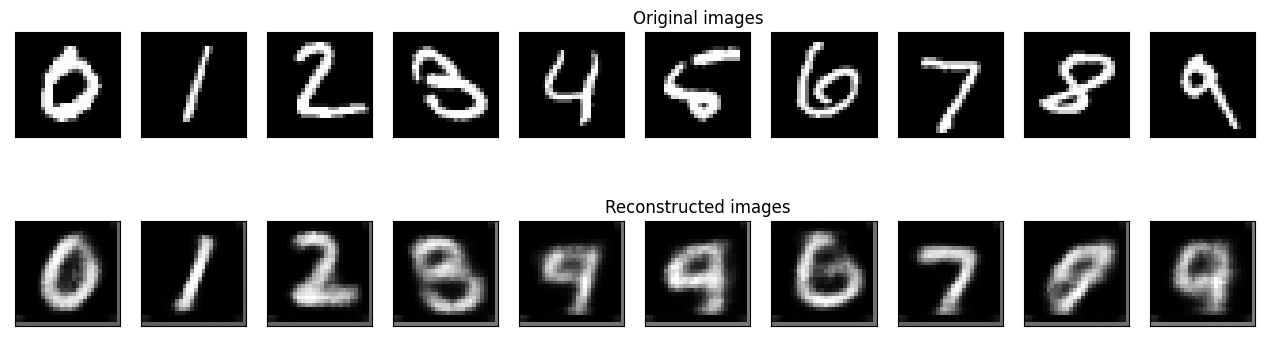


 EPOCH 7/500 	 train loss 187.719 	 val loss 187.380


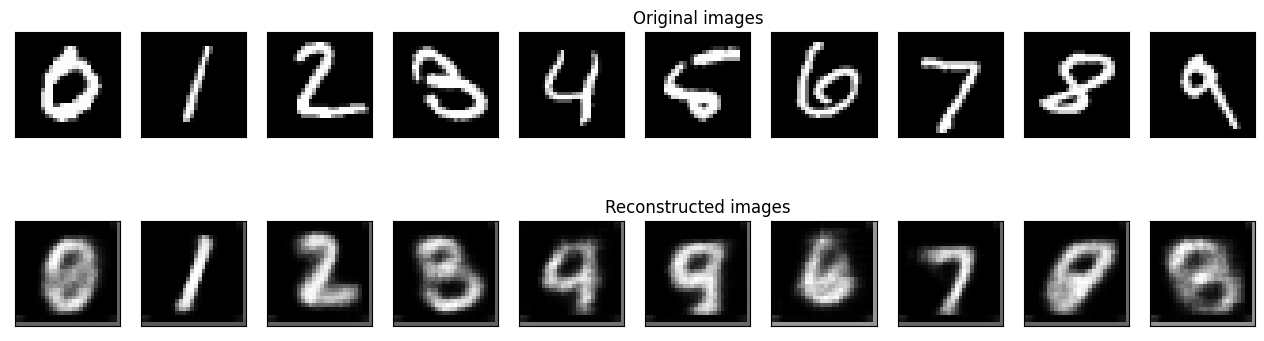


 EPOCH 8/500 	 train loss 184.762 	 val loss 184.098


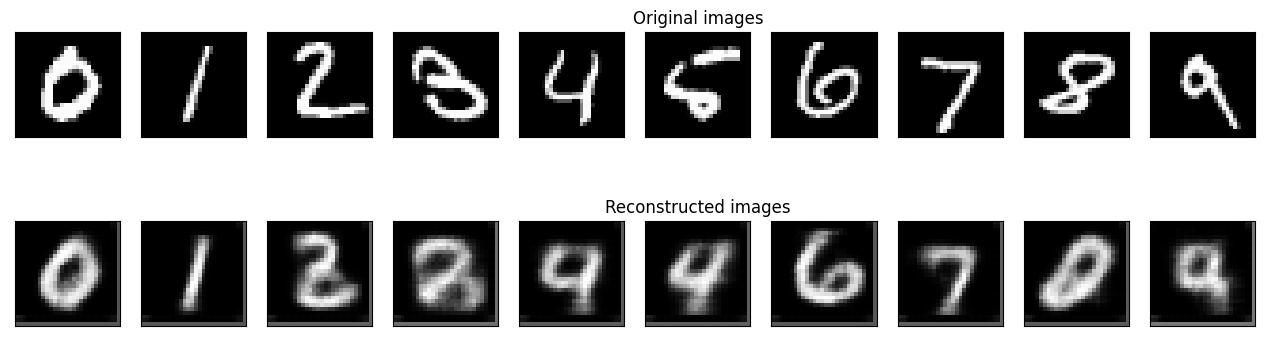


 EPOCH 9/500 	 train loss 182.296 	 val loss 181.877


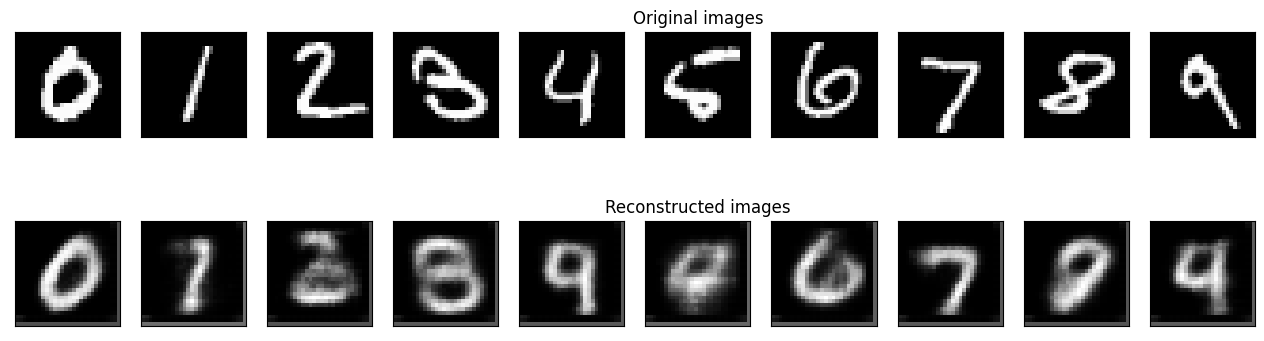


 EPOCH 10/500 	 train loss 180.070 	 val loss 179.338


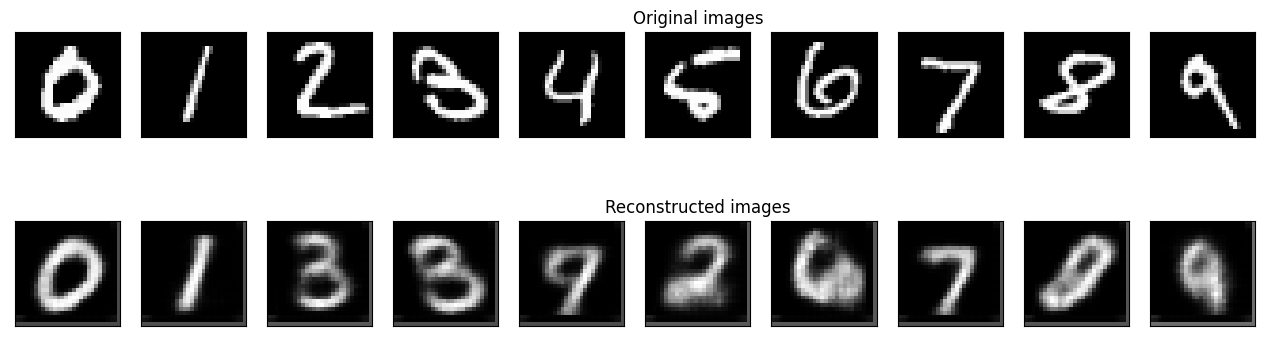


 EPOCH 11/500 	 train loss 178.001 	 val loss 177.602


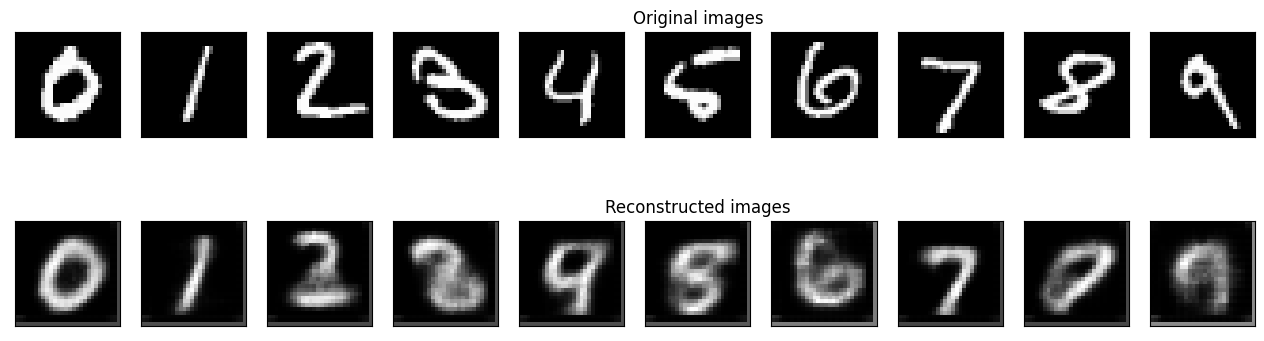


 EPOCH 12/500 	 train loss 175.926 	 val loss 175.779


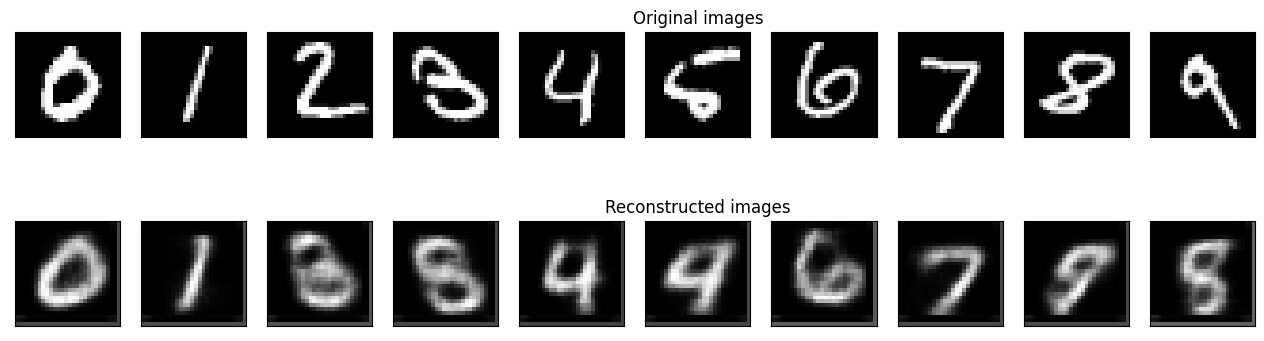


 EPOCH 13/500 	 train loss 174.179 	 val loss 174.122


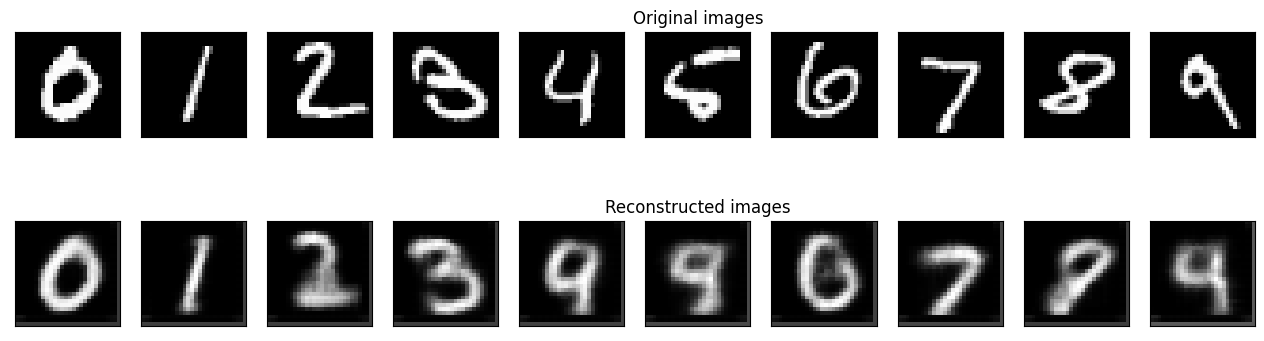


 EPOCH 14/500 	 train loss 172.704 	 val loss 172.424


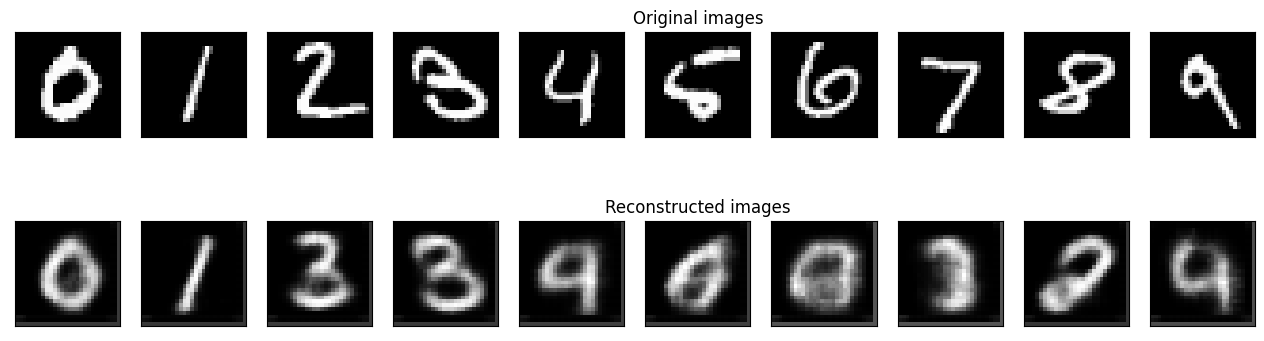


 EPOCH 15/500 	 train loss 171.253 	 val loss 171.078


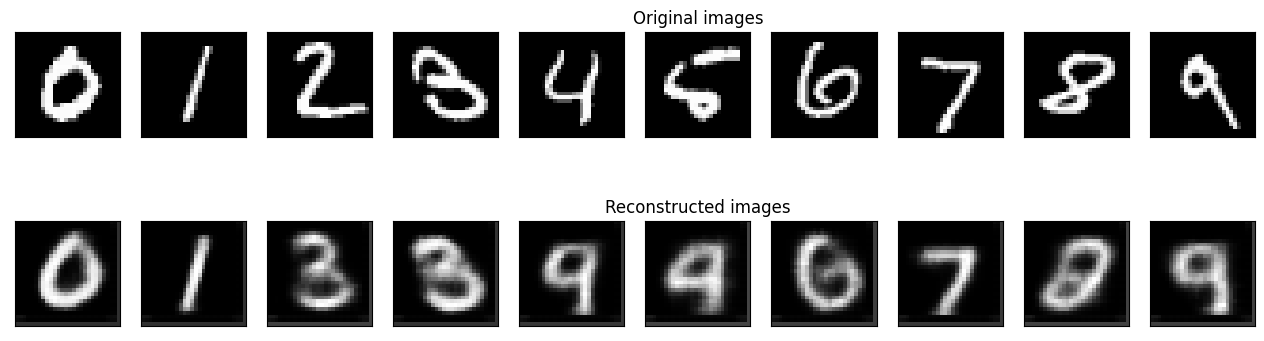


 EPOCH 16/500 	 train loss 169.819 	 val loss 169.918


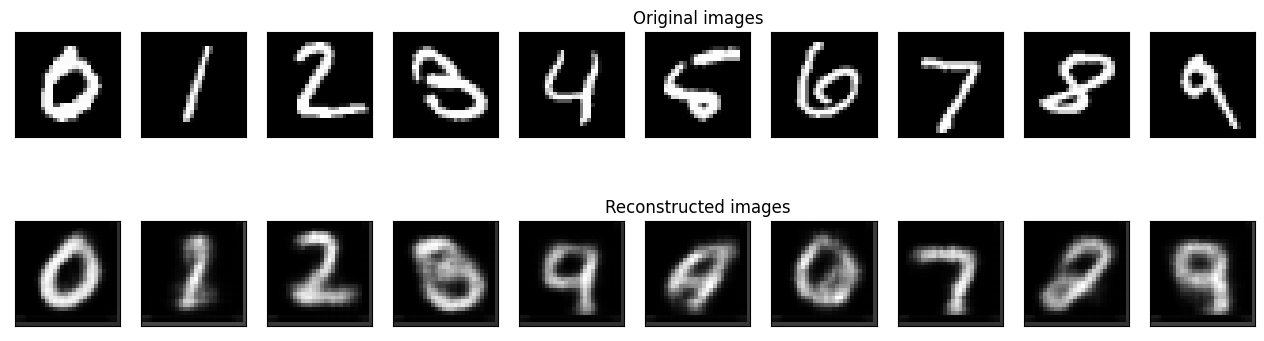


 EPOCH 17/500 	 train loss 168.762 	 val loss 168.873


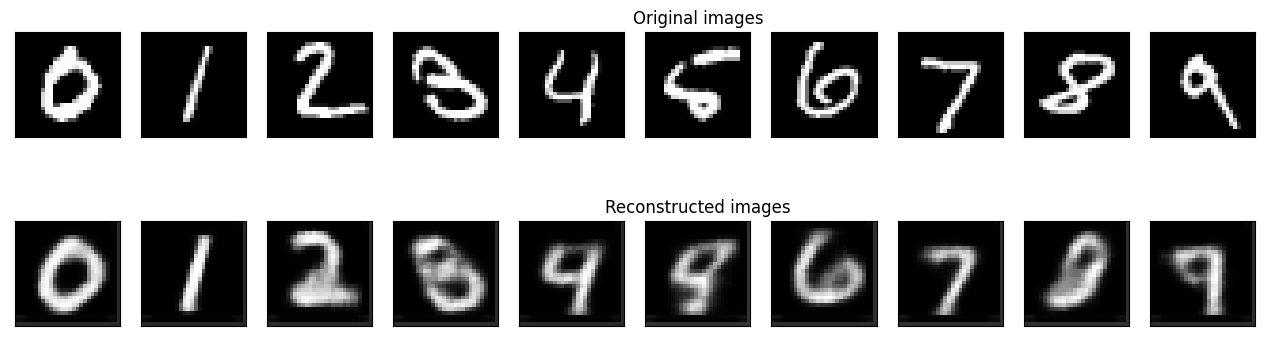


 EPOCH 18/500 	 train loss 167.627 	 val loss 167.441


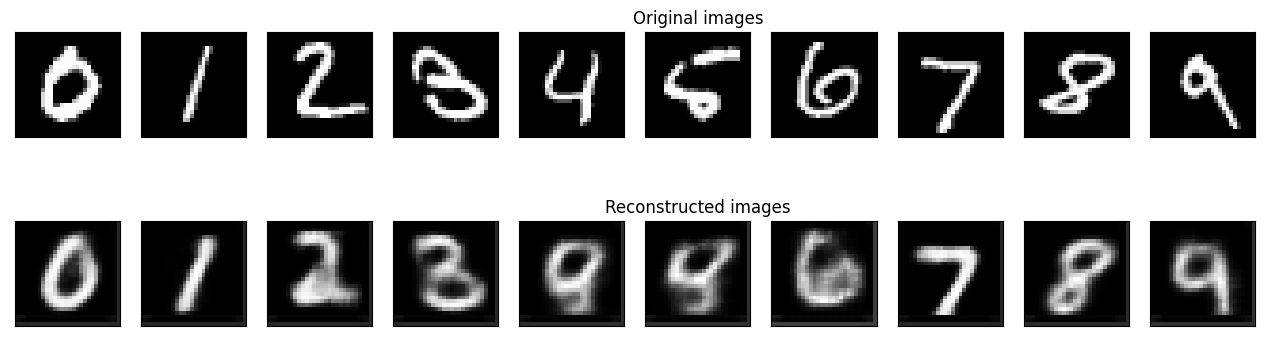


 EPOCH 19/500 	 train loss 166.534 	 val loss 166.713


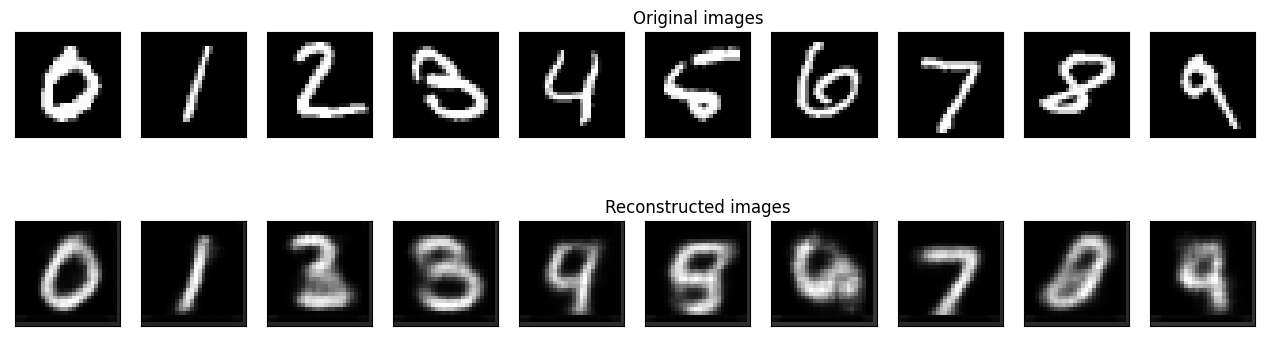


 EPOCH 20/500 	 train loss 165.763 	 val loss 166.058


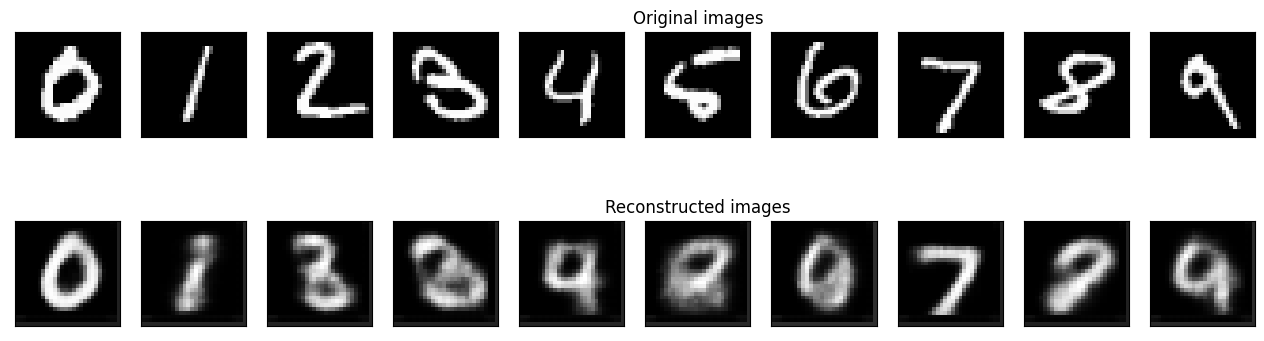


 EPOCH 21/500 	 train loss 164.846 	 val loss 165.120


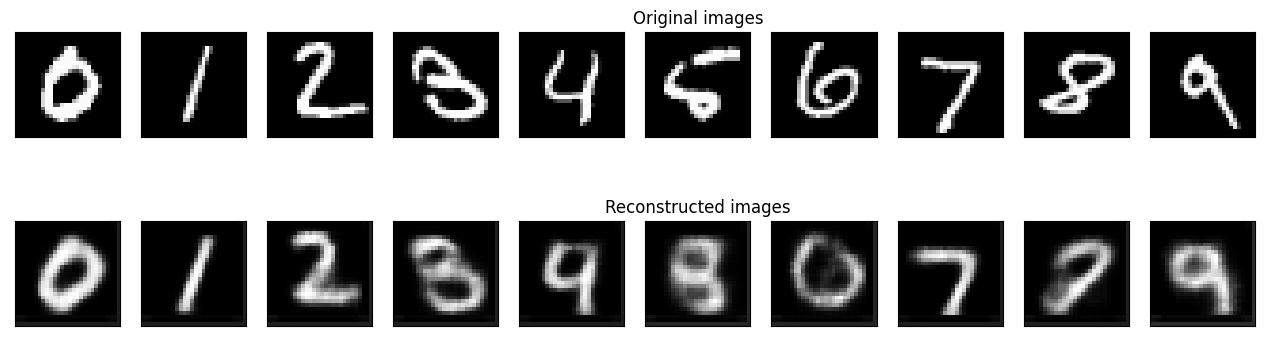


 EPOCH 22/500 	 train loss 164.132 	 val loss 164.417


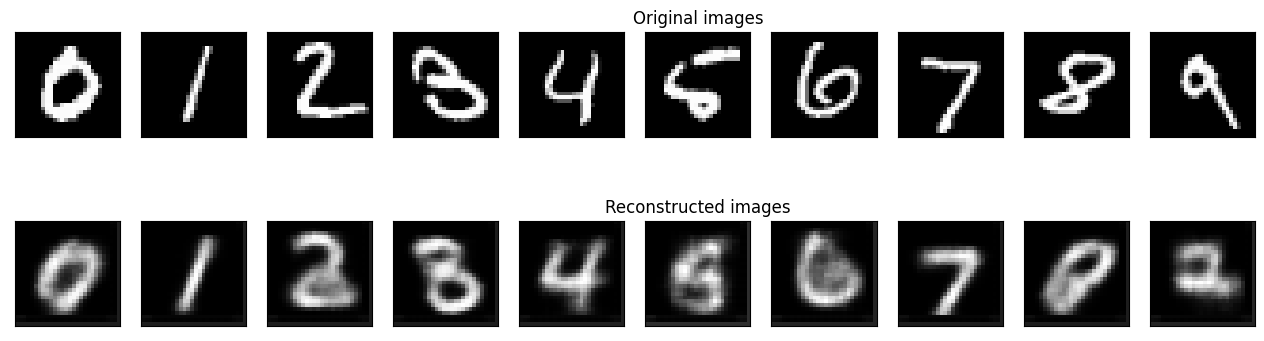


 EPOCH 23/500 	 train loss 163.286 	 val loss 163.410


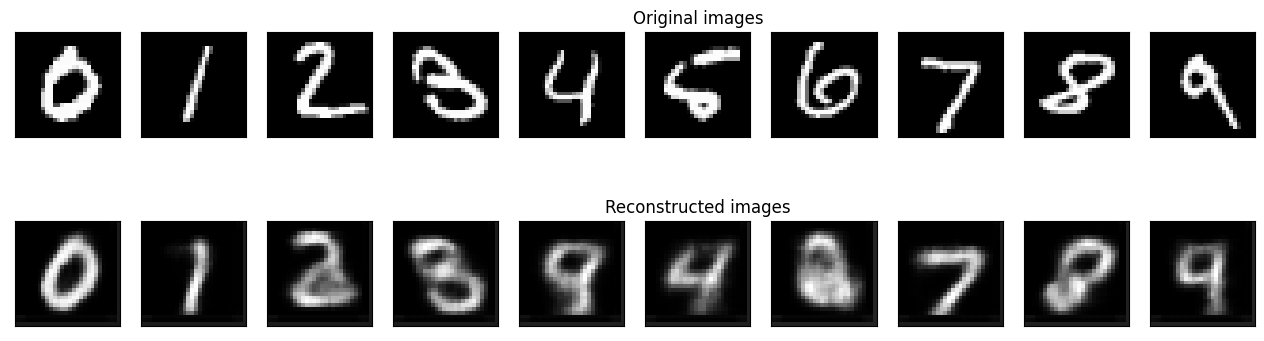


 EPOCH 24/500 	 train loss 162.662 	 val loss 163.093


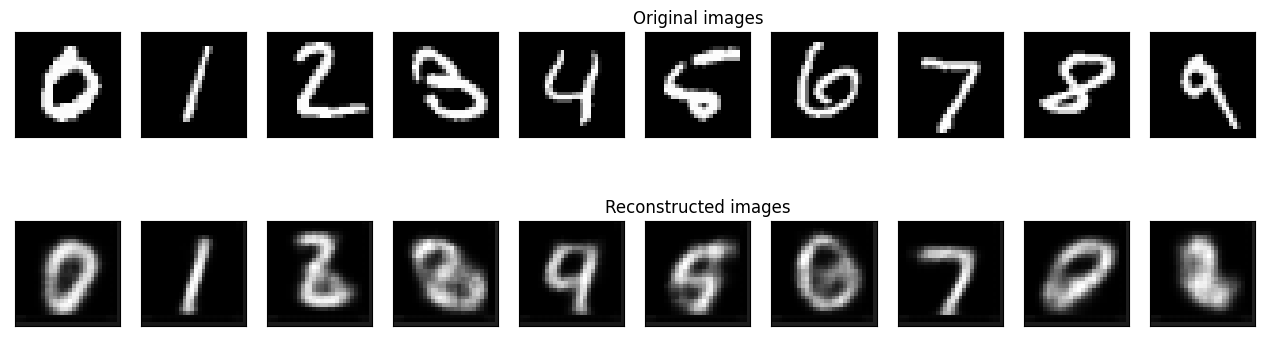


 EPOCH 25/500 	 train loss 162.032 	 val loss 162.143


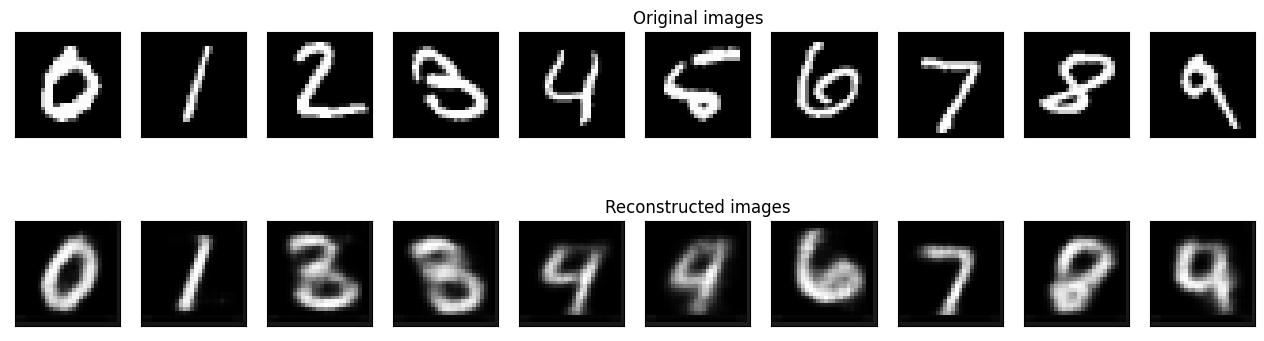


 EPOCH 26/500 	 train loss 161.692 	 val loss 162.111


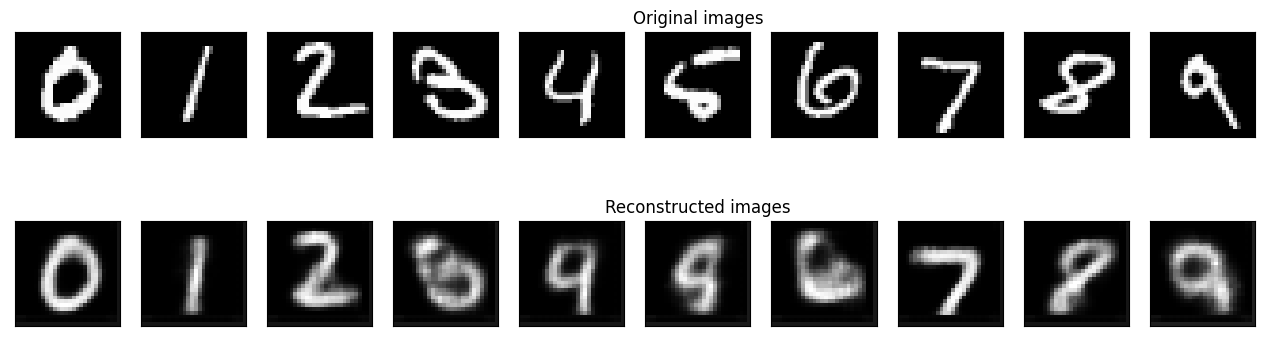


 EPOCH 27/500 	 train loss 161.167 	 val loss 161.484


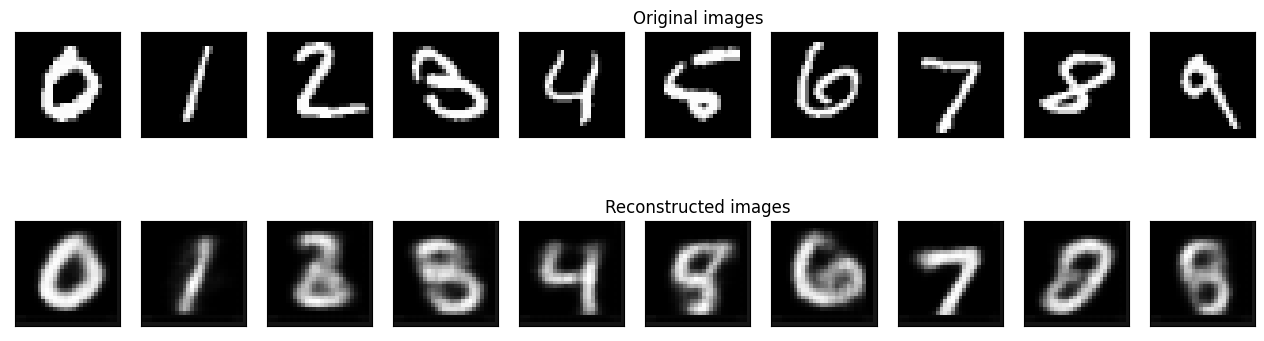


 EPOCH 28/500 	 train loss 160.819 	 val loss 160.953


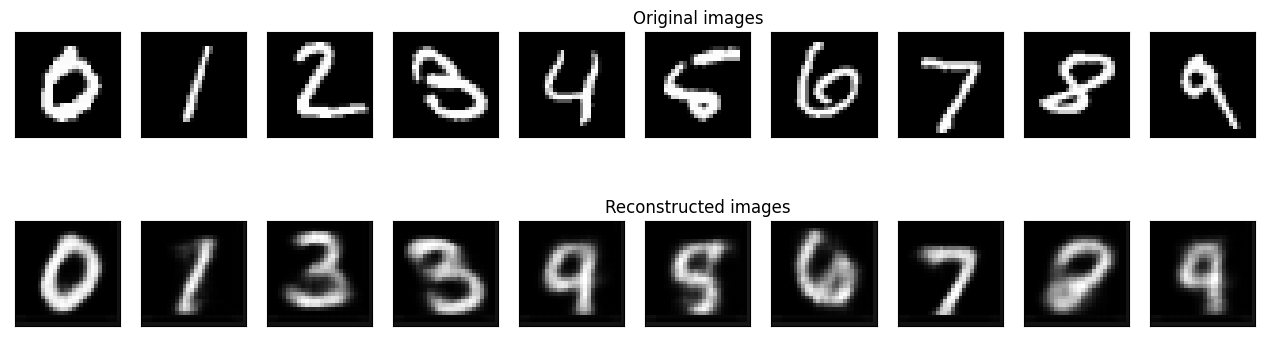


 EPOCH 29/500 	 train loss 160.108 	 val loss 160.597


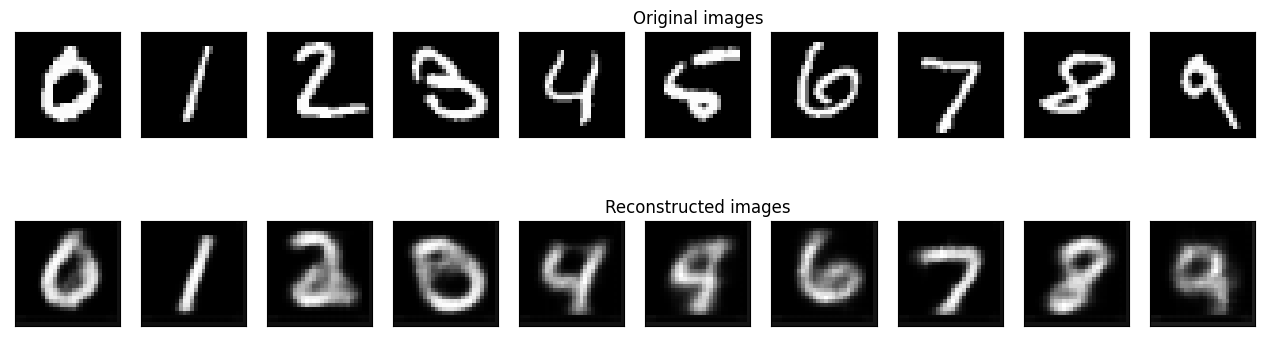


 EPOCH 30/500 	 train loss 159.907 	 val loss 160.250


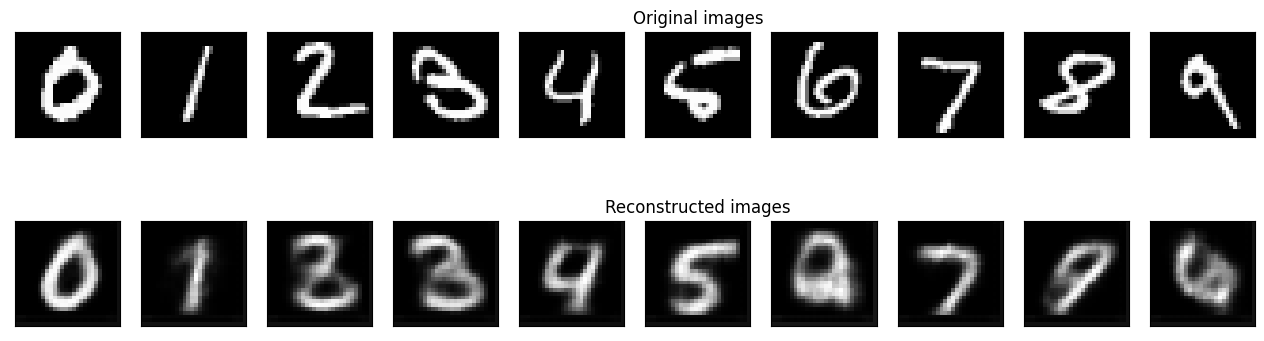

KeyboardInterrupt: 

In [35]:
num_epochs = 500
val_losses = []

print("Beginning training")
plot_ae_outputs(vae, n=10)

for epoch in range(num_epochs):
    train_loss = train_epoch(vae, device, train_loader, optim)
    val_loss = test_epoch(vae, device, valid_loader)
    val_losses.append(val_loss)
    print(
        "\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}".format(
            epoch + 1, num_epochs, train_loss, val_loss
        )
    )
    plot_ae_outputs(vae, n=10)
    if len(val_losses) >= 5 and val_losses[-5] < val_loss:
        print("Validation loss is no longer shrinking. Quitting early.")
        break


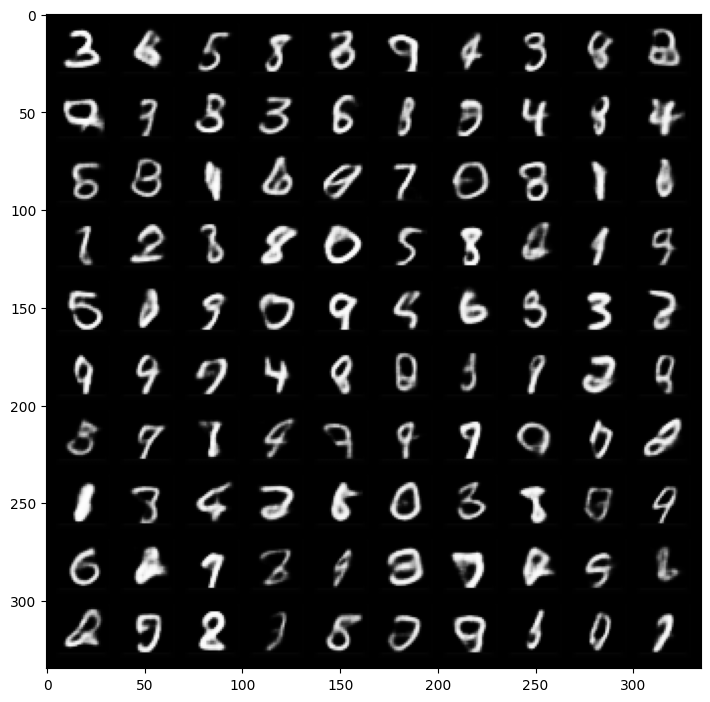

In [29]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():
    # sample latent vectors from the normal distribution
    latent = torch.randn(100, latent_dims, device=device) * .8

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data, 10, 5))
    plt.show()


tensor([[ 2.2916e-02, -5.0186e-01,  6.2051e+03,  ...,  2.3110e+00,
         -1.4064e+00,  2.0922e-01],
        [-2.2508e-02,  1.7085e+00, -5.7744e-01,  ...,  5.5726e-01,
          3.1791e-01,  1.6750e+00],
        [-4.3380e-01, -9.3400e-01, -2.8551e+05,  ...,  9.1685e-01,
         -4.3502e-01, -1.4294e+00],
        ...,
        [-1.4577e+00,  1.2721e+00, -4.1739e+09,  ..., -1.9272e+00,
         -8.0578e-01, -5.9020e-01],
        [ 8.2467e-01,  8.0131e-01,  6.3114e-01,  ...,  1.8858e-01,
          2.1068e-02,  1.3538e+00],
        [-1.3162e-01, -3.8839e-01,  1.4816e+00,  ...,  1.3079e+00,
         -6.0711e-01, -2.6463e-01]], device='cuda:0')


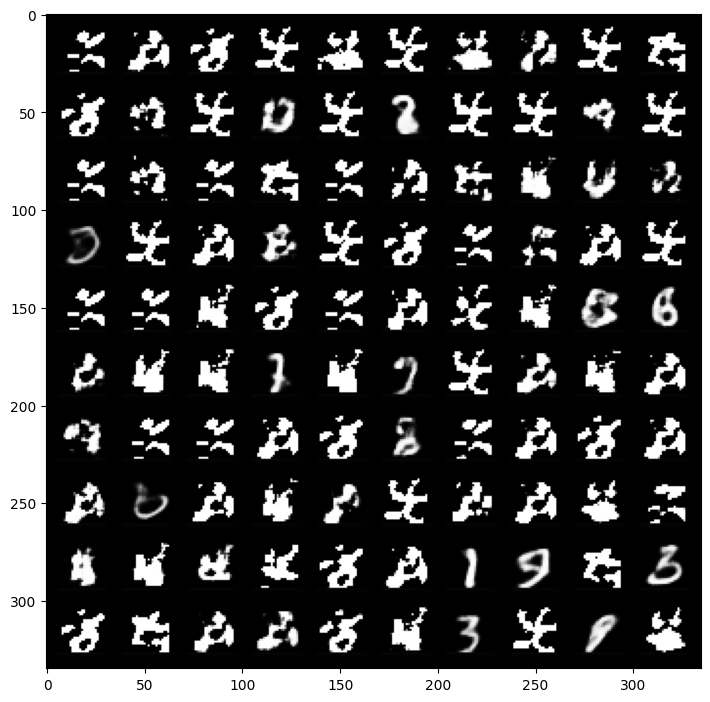

In [31]:
zeroes = [
    train_dataset.data[i]
    for i, label in enumerate(train_dataset.targets)
    if label == 0
]
zeroes = zeroes[:100]
zeroes = einops.rearrange(torch.stack(zeroes).type(torch.float32), "b h w -> b 1 h w")
zeroes.to(device)
with torch.no_grad():
    vae.eval()
    _, mu, log_var = vae.encoder(zeroes)

    # Average mu and log_var for zeroes in our dataset
    mu_avg = einops.reduce(mu, "b mu -> mu", "mean").cpu()
    log_var_avg = einops.reduce(log_var, "b l -> l", "mean").cpu()
    std_avg = log_var.cpu().mul(0.5).exp_()

    # Generate a bunch of zeroes from latent sampling
    esp = torch.randn(100, latent_dims, dtype=torch.float32)
    z = (esp.mul(std_avg).add(esp)).to(device)
    print(z)

    img_recon = vae.decoder(z)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data, 10, 5))
    plt.show()


# def display(images):
#     fig, axs = plt.subplots(10, 10, figsize=(10, 10))
#     for i, image in enumerate(images):
#         axs[i // 10, i % 10].imshow(image, cmap="gray")
#     plt.show()
